In [8]:
mkdir project

In [11]:
cd project

/content/project


## Installing PySpark
Why to use PySpark in the project?
- It speeds up the processes.
- Fully resource utilization.

Pyspark is an python API or an interface for spark which uses distributed processing to analyze, manipulate or work on datasets.
Pyspark uses SQL like commands to work on the dataset.

In [ ]:
!pip install pyspark  #to use some functionalities of spark

## Importing required python libraries

In [ ]:
import pyspark
from pyspark.sql import SparkSession    #to create a sparksession
#import pyspark.sql.functions as F
from pyspark.sql import functions as F    #to use sql queries
import pyspark.sql as sparksql    #to perform sql opertions
import pandas as pd
import warnings
warnings.filterwarnings('ignore')   #to ignore warnings if we get any

In [ ]:
#initialize the session
#SparkSession = it is the entry point to use any spark functionalities & to create a dataframe
#                using spark session our data will not directly get stored on disk but some of the memory is provided to run our applications
#getOrCreate - to create new session or use existing(already created) session
spark = SparkSession.builder.appName('loan_prediction').getOrCreate()   # allows you to run SQL queries on database tables.

# **1. Data Analysis**

In [ ]:
#Displaying the dataset & storing it into dataframe df
df = spark.read.csv('train.csv', header=True, sep=',', inferSchema=True)
df.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [ ]:
# display total count  of approved/rejected applications based on loan status
df.groupBy('Loan_Status').count().show()    #grouping the loan status column with similar value

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  422|
|          N|  192|
+-----------+-----+



In [ ]:
#gives more description about dataset attributes
df.printSchema()

In [ ]:
#displaying average of credit history, people with approval status have high Credit History
df.select("Credit_History", "Loan_Status").groupBy('Loan_Status').agg(F.avg('Credit_History')).show()

+-----------+-------------------+
|Loan_Status|avg(Credit_History)|
+-----------+-------------------+
|          Y| 0.9818181818181818|
|          N| 0.5418994413407822|
+-----------+-------------------+



In [ ]:
#Gender Based Analysis
#Majority Applicants - Male
df.select('Gender', 'Loan_Status').groupBy('Loan_Status', 'Gender').count().show()

+-----------+------+-----+
|Loan_Status|Gender|count|
+-----------+------+-----+
|          N|Female|   37|
|          Y|  null|    8|
|          Y|Female|   75|
|          N|  null|    5|
|          Y|  Male|  339|
|          N|  Male|  150|
+-----------+------+-----+



## **1.1 Correlation Matrix**

In [ ]:
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']  #take all numeric columns
corr_df = pd.DataFrame()  #creating empty dataframe
for i in columns:
    corr = []
    for j in columns:
        #round() - to round of the decimal value upto 2
        corr.append(round(df.stat.corr(i, j), 2))   #
    corr_df = pd.concat([corr_df, pd.Series(corr)], axis=1)   #generating list of list
corr_df.columns = columns   #appending all 5 columns in our dataframe
corr_df.insert(0, '', columns)    #
corr_df.set_index('')   #setting the columns again as our indexes

#All attributes have less or same correlation with loan amount or less impact on the loan amount
#ApplicantIncome, CoapplicantIncome have some positive impact on loan amount

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
,,,,,
ApplicantIncome,1.00,-0.12,0.54,-0.02,0.01
CoapplicantIncome,-0.12,1.00,0.19,-0.05,-0.06
LoanAmount,0.54,0.19,1.00,0.06,-0.03
Loan_Amount_Term,-0.02,-0.05,0.06,1.00,0.05
Credit_History,0.01,-0.06,-0.03,0.05,1.00


In [ ]:
df.createOrReplaceTempView('table')   #to create new table or use existing table & storing our df in it

In [ ]:
# limit = display upto 5 rows from the table using sql select query
spark.sql("select * from table limit 5").show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [ ]:
#displaying total count of applications with Credit History 1
spark.sql('select count(*) from table where Credit_History=1').show()

+--------+
|count(1)|
+--------+
|     475|
+--------+



In [ ]:
#displaying Loan IDs of applications of the users whose Credit History is 1
spark.sql('select Loan_ID from table where Credit_History=1').show()

+--------+
| Loan_ID|
+--------+
|LP001002|
|LP001003|
|LP001005|
|LP001006|
|LP001008|
|LP001011|
|LP001013|
|LP001018|
|LP001020|
|LP001024|
|LP001027|
|LP001028|
|LP001029|
|LP001030|
|LP001032|
|LP001038|
|LP001041|
|LP001046|
|LP001066|
|LP001068|
+--------+
only showing top 20 rows



## **2.1 Matrix Representation of NULL values**

# **2. Data Visualization**

<Axes: >

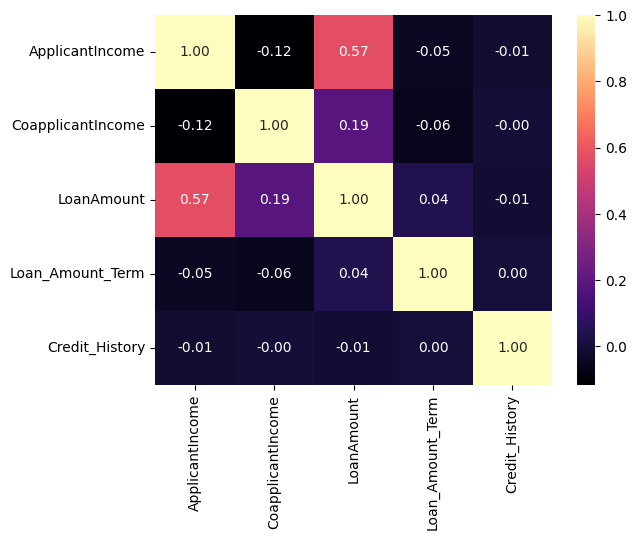

In [ ]:
# Displaying Correlation Matrix(nxn, where n = no. of columns) with the help of HeatMap
plt.figure()
sns.heatmap(df1.corr(),annot=True,cmap="magma",fmt='.2f')

In [ ]:
import pandas as pd
import missingno as msno  #to display NULL values graphically
import seaborn as sns   #for heatmap, countplot, distplot
import matplotlib.pyplot as plt   #for labelling, figuresize
df1 = pd.read_csv('train.csv')
df1

<Axes: >

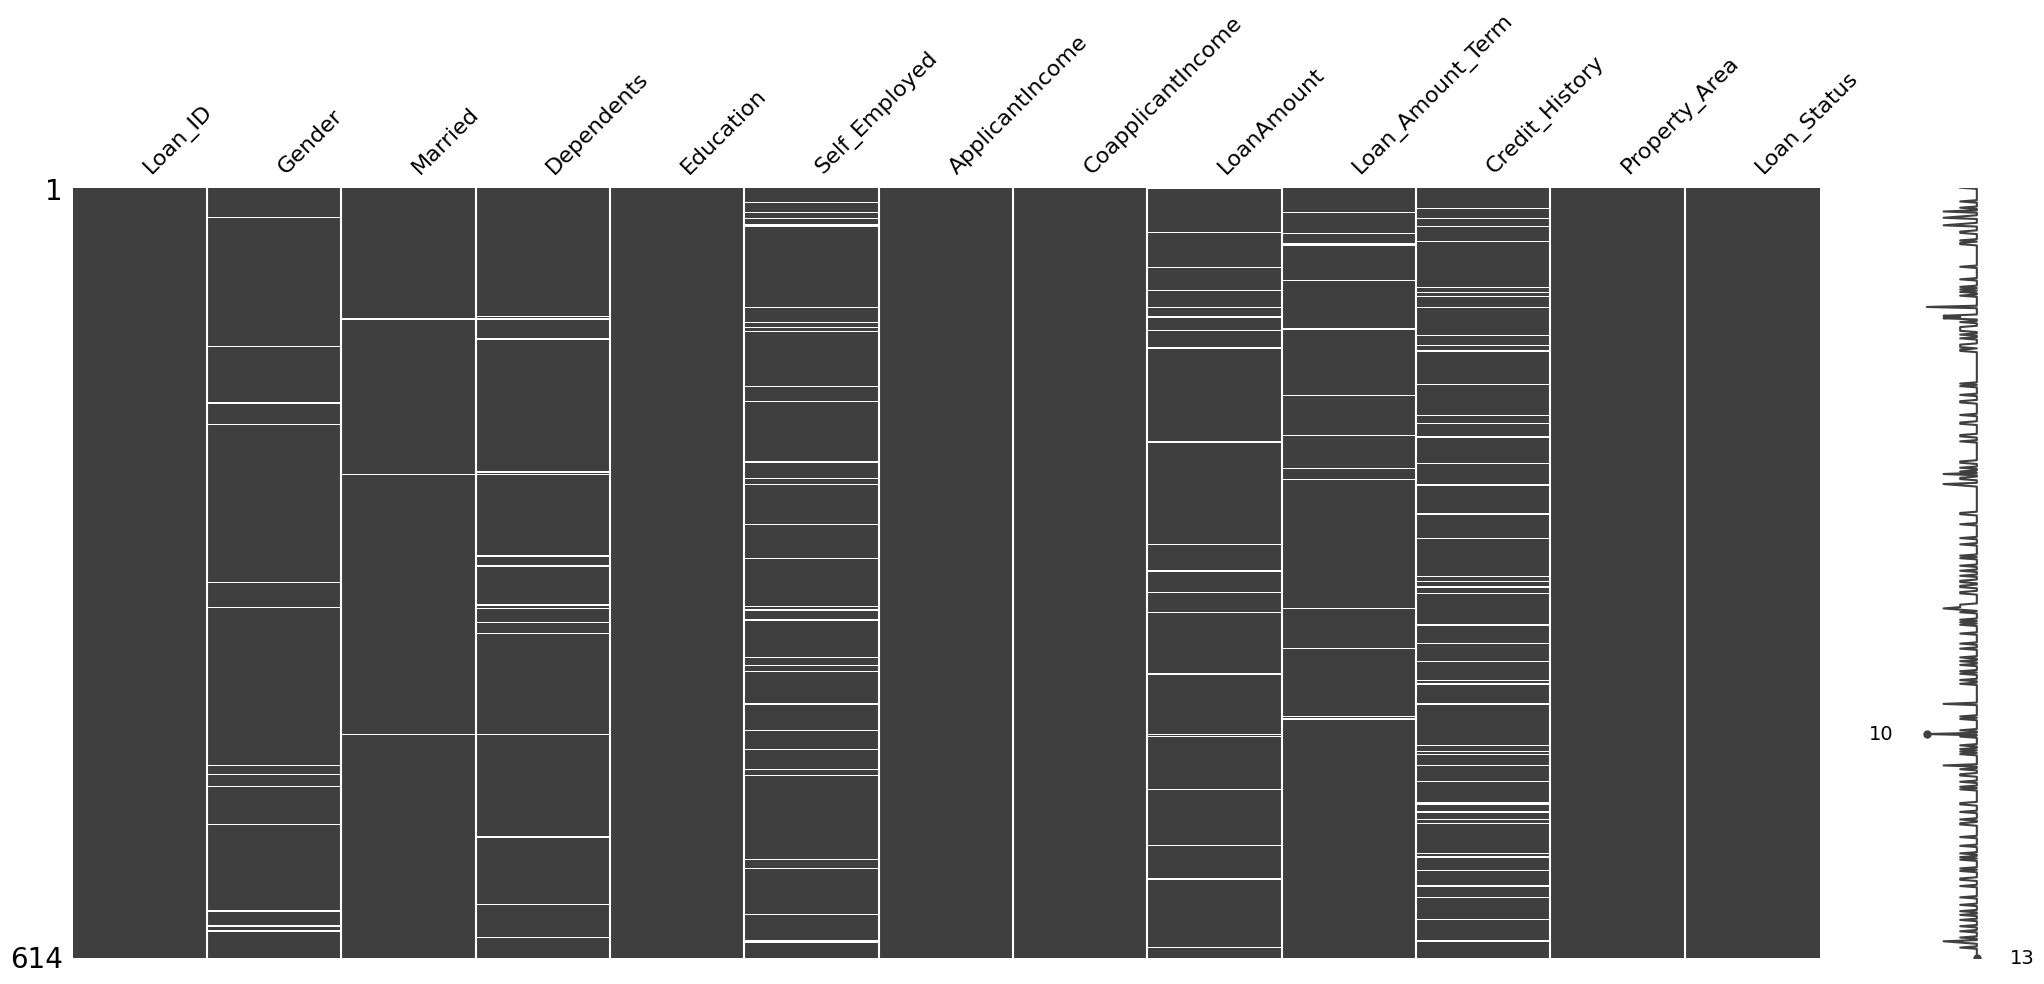

In [ ]:
# Displaying NULL values in terms of matrix format
msno.matrix(pandas_df)

## **2.2 Correlation Matrix with HeatMap**

## **2.3 Countplot**

Text(0.5, 1.0, 'Loan Status Approval/Rejection based on Credit History of Applicant\n Negative Credit History = 0   Positive Credit History = 1\n')

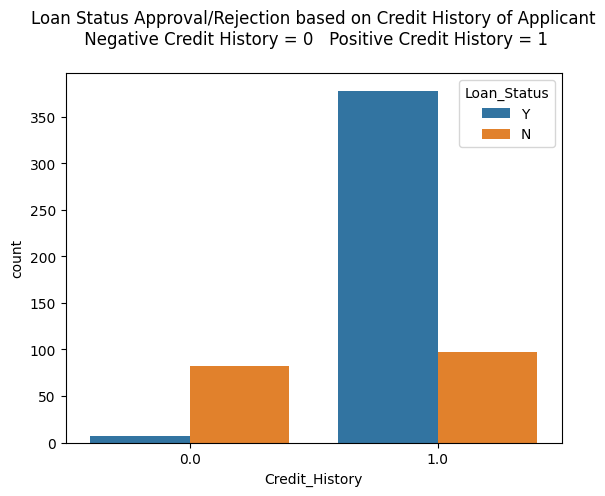

In [ ]:
# Displaying Total Count of Loan Status(Approved/Rejected) based on Credit History
sns.countplot(data= df1, x='Credit_History',hue='Loan_Status')
plt.title('Loan Status Approval/Rejection based on Credit History of Applicant\n Negative Credit History = 0   Positive Credit History = 1\n')

## **2.4 Countplot**

Text(0.5, 1.0, 'Loan Status Approval/Rejection based on Gender on Applicant\n')

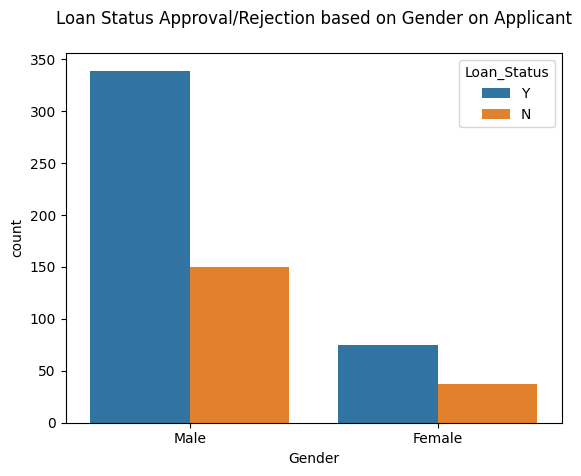

In [ ]:
# Displaying Total Count of Loan Status(Approved/Rejected) based on Credit History
sns.countplot(data= df1, x='Gender',hue='Loan_Status')
plt.title('Loan Status Approval/Rejection based on Gender on Applicant\n')

## **2.5 Distplot**

Text(0.5, 1.0, 'Loan Status Summary based on LoanAmount of an Applicant\n')

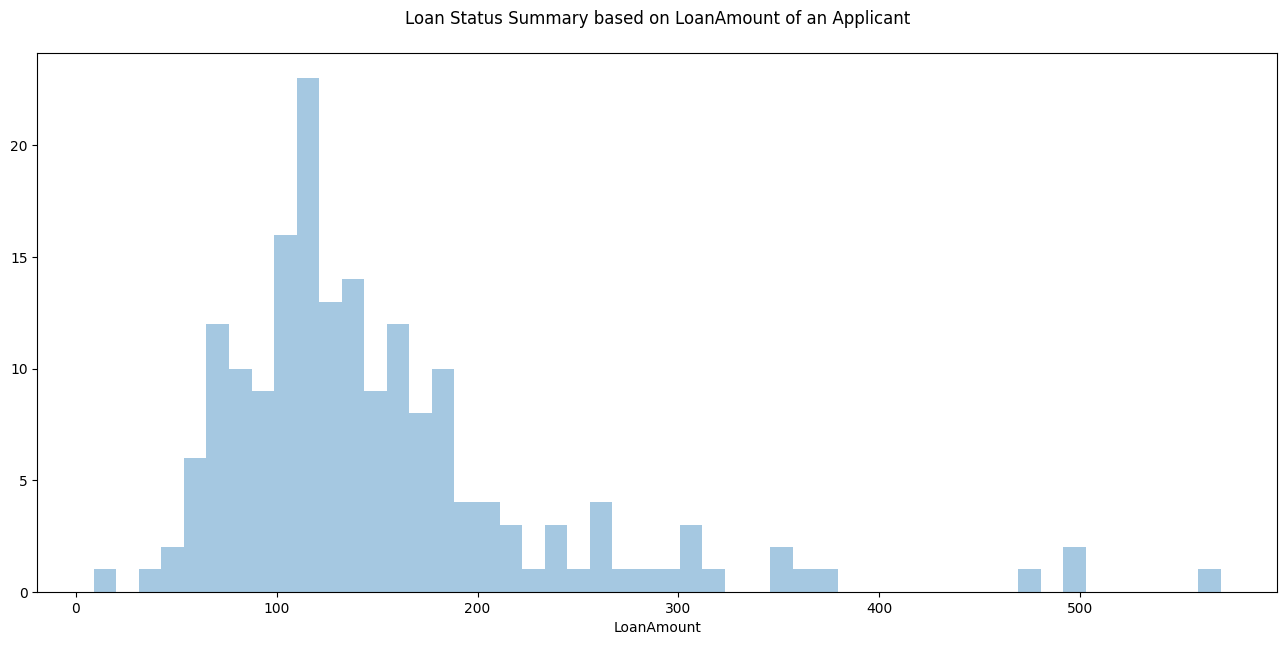

In [ ]:
# Displaying displot of LoanAmount vs Loan Status
plt.figure(figsize=(16,7))
sns.distplot(df1[df1['Loan_Status'] == 'N']['LoanAmount'],kde=False,bins=50)
plt.title('Loan Status Summary based on LoanAmount of an Applicant\n')

## **2.6 ClusterMap**

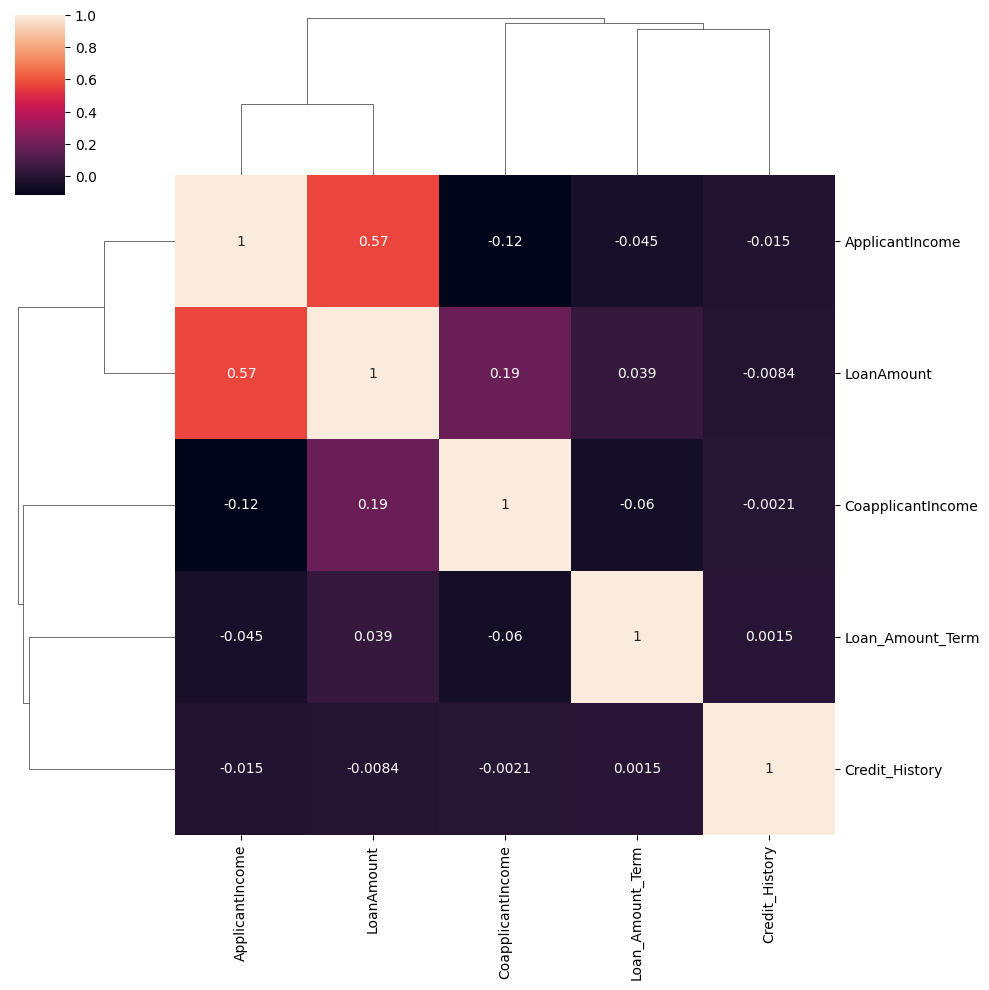

In [ ]:
#Displaying clustered features in the form of map
sns.clustermap(df1.corr(),annot=True)
# plt.figure(figsize=(5,5))

# **3. Data Preprocessing**
- Treating NULL values.
- Handling Categorical data.

In [ ]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
df = df.na.fill(mean, ['LoanAmount'])

In [ ]:
mean = df.select(F.mean(df['LoanAmount'])).collect()[0][0]
mean

146.41216216216216

In [ ]:
#fill null values with mean value
for col in numerical_cols:
    mean = df.select(F.mean(df[col])).collect()[0][0]
    df = df.na.fill(mean, [col])

In [ ]:
# get mode value of column
#groupBy() =
#orderBy() =

#most common value in the dataset with its count and gender
df.groupby('Gender').count().orderBy("count", ascending=False).first()[0]

'Male'

In [ ]:
# fill null values for all the columns
#separate numeric data & categorical data into 2 separate columns
numerical_cols = ['LoanAmount', 'Loan_Amount_Term']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']

In [ ]:
#fill null values with mean value
for col in categorical_cols:
    mode = df.groupby(col).count().orderBy("count", ascending=False).first()[0]
    df = df.na.fill(mode, [col])

In [ ]:
# displaying that no NULL value is present now
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
# create new feature TotalIncome
#TotalIncome = Applicant Income + Coapplicant Income
df = df.withColumn('TotalIncome', F.col('ApplicantIncome') + F.col('CoapplicantIncome'))
df.show(2)

+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|LP001002|  Male|     No|         0| Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          Y|     5849.0|
|LP001003|  Male|    Yes|         1| Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|     6091.0|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+---------------

In [ ]:
# how to find and replace values
#mapping loan status to 1 if approved , else 0 if rejected
df = df.withColumn('Loan_Status', F.when(df['Loan_Status']=='Y', 1).otherwise(0))
df.show(2)

+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|LP001002|  Male|     No|         0| Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          1|     5849.0|
|LP001003|  Male|    Yes|         1| Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          0|     6091.0|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+---------------

In [ ]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- TotalIncome: double (nullable = true)



# **4. Feature Engineering**

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome']

# index the string columns
indexers = [StringIndexer(inputCol=col, outputCol="{0}_index".format(col)) for col in categorical_columns]
# encode the indexed values
encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
           for indexer in indexers]

#inputting the encoded columns into new variable
input_columns = [encoder.getOutputCol() for encoder in encoders] + numerical_columns
# vectorize the encoded values
assembler = VectorAssembler(inputCols=input_columns, outputCol="feature")

In [ ]:
indexers

[StringIndexer_6ce606e1933f,
 StringIndexer_bb126c1a2b94,
 StringIndexer_84a5d68a45b0,
 StringIndexer_e1c4ef53ae32,
 StringIndexer_695f83123c47,
 StringIndexer_d3efe4927575,
 StringIndexer_7201b16422d7]

In [ ]:
# create the pipeline to transform the data
#integreating all the inputs into pipeline vaariable
pipeline = Pipeline(stages = indexers + encoders + [assembler])

In [ ]:
data_model = pipeline.fit(df)

In [ ]:
transformed_df = data_model.transform(df)

In [ ]:
transformed_df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+------------+-------------+----------------+---------------+-------------------+-------------------+--------------------+--------------------+---------------------+------------------------+-----------------------+---------------------------+---------------------------+----------------------------+--------------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|Gender_index|Married_index|Dependents_index|Education_index|Self_Employed_index|Property_Area_index|Credit_History_index|Gender_index_encoded|Married_index_encoded|Dependents_index_encoded|Education_index_encoded|Self_Employed_index_encoded|Property_Area_index_encoded|Credit_History_index_encoded|             feature|
+---

In [ ]:
# get input feature and output columns
#input - feature column(contains all information)
#output - loan_status
transformed_df = transformed_df.select(['feature', 'Loan_Status'])

In [ ]:
transformed_df

DataFrame[feature: vector, Loan_Status: int]

In [ ]:
# split the data for train and test
#seed variable instead of random_State - used to get same split everytime
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
train_data.show(5)

+--------------------+-----------+
|             feature|Loan_Status|
+--------------------+-----------+
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          0|
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
+--------------------+-----------+
only showing top 5 rows



1. Logistic Regression

In [ ]:
pred = lr_model.transform(train_data)
pred.show()

+--------------------+-----------+--------------------+--------------------+----------+
|             feature|Loan_Status|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(22,[0,2,4,8,10,1...|          1|[-2.1070239086977...|[0.10841600655333...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.3429104139971...|[0.08763094266577...|       1.0|
|(22,[0,2,4,8,10,1...|          0|[-2.4403821055376...|[0.08014473823723...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.2495158930035...|[0.09539123115445...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.0600035915415...|[0.11304546996138...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1481365618389...|[0.10450548280147...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.2152437624502...|[0.09838992182301...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1442818561265...|[0.10486677225954...|       1.0|
|(22,[0,2,4,8,10,1...|          

In [ ]:
# prediction based on test data
predictions = lr_model.transform(test_data)
predictions.show()

+--------------------+-----------+--------------------+--------------------+----------+
|             feature|Loan_Status|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(22,[0,2,4,8,10,1...|          1|[-2.1309019654107...|[0.10612939546952...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1965880165663...|[0.10005730505861...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1183870711017...|[0.10732249829704...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1420673697694...|[0.10507482746799...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.1120272450757...|[0.10793332086955...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-1.8438581820741...|[0.13659563082672...|       1.0|
|(22,[0,2,4,8,10,1...|          0|[-1.9917058610226...|[0.12007650752153...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-1.9866327570695...|[0.12061355619972...|       1.0|
|(22,[0,2,4,8,10,1...|          

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator   #for Evaluation of our model

# **5. Model Building**
Using Logistic Regression Model & Random forest Classifier.

In [ ]:
lr = LogisticRegression(featuresCol='feature', labelCol='Loan_Status')
lr_model = lr.fit(train_data)

In [ ]:
#Generating AUC metric for Logistic Regression Model
predictions = lr_model.transform(test_data)
auc = BinaryClassificationEvaluator().setLabelCol('Loan_Status')
print('AUC:', str(auc.evaluate(predictions)))

AUC: 0.782010582010582


2. Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(featuresCol='feature', labelCol='Loan_Status')
rf_model = rf.fit(train_data)

In [ ]:
predictions = rf_model.transform(test_data)
auc = BinaryClassificationEvaluator().setLabelCol('Loan_Status')
print('AUC:', str(auc.evaluate(predictions)))

AUC: 0.8182539682539682
